<a href="https://colab.research.google.com/github/Diego-II/Procesamiento-Avanzado-de-Imagenes/blob/master/Tarea4/Tarea4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 4: Deteccion de personas usando caracteristicas de tipo HOG.
## Diego Irarrazaval

# 1. Introduccion:
 
- En la siguiente tarea se explorara e implementara el extractor de caracteristicas HOG [(Paper Original)](http://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf). 
- Para lograr esto, se deben obtener los gradientes en 'x' e 'y' (similar a la tarea 2) y luego obtener estos gradientes en coordenadas polares. El ultimo paso corresponde al calculo y normalizacion de los histogramas de gradientes. 
- Se espera que a pesar del 'pequeno' dataset de entrenamiento, se obtengan buenos resultados en los clasificadores producto de un gran trabajo de extraccion de caracteristicas. 

En las siquientes secciones:
1. se muestra el desarrollo e implementacion de las funciones necesarias para poder obtener las caracteristicas de HOG. 
2. Se entrena un clasificador SVC utilizando una busqueda de grilla
3. Se entrena un clasificador RandomForest con busqueda de grilla. 
4. Se prueban ambos clasificadores en el conjunto de test y se grafica la matriz de confusion. 




In [ ]:
import os.path 
try:
  import google.colab as colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Cargamos los datos solo la primera vez que nos conectamos a la "runtime":
# La descarga se hace automatica desde un repo en github
if IN_COLAB:
  !pip install -U opencv-python
  %load_ext Cython
  from google.colab.patches import cv2_imshow
  if os.path.exists('/content/imagenes_tarea4_2020.zip'):
    print("Datos ya descargados")
  else:
    !wget https://github.com/Diego-II/Procesamiento-Avanzado-de-Imagenes/raw/master/Tarea4/imagenes_tarea4_2020.zip
    !unzip /content/imagenes_tarea4_2020

In [2]:
!ls

car_side  chair  imagenes_tarea4_2020.zip  pedestrian  sample_data


In [3]:
import glob
import cv2
import numpy as np

En la siguiente celda se realiza la carga de las imagenes y la transformacion a escala de grises de (64x128)

In [4]:

car_side_dir = '/content/car_side/'
chair_dir = '/content/chair/'
pedestrian_dir = '/content/pedestrian/'

car_side = []
chair = []
pedestrian = []

for im in glob.glob(pedestrian_dir+'*.png'):
  temp = cv2.cvtColor(cv2.imread(im), cv2.COLOR_BGR2GRAY)
  pedestrian.append(cv2.resize(temp, dsize = (64,128)))

for im in glob.glob(chair_dir+'*.jpg'):
  temp = cv2.cvtColor(cv2.imread(im), cv2.COLOR_BGR2GRAY)
  chair.append(cv2.resize(temp, dsize = (64,128)))

for im in glob.glob(car_side_dir+'*.jpg'):
  temp = cv2.cvtColor(cv2.imread(im), cv2.COLOR_BGR2GRAY)
  car_side.append(cv2.resize(temp, dsize = (64,128)))

In [5]:
show_im = False
if show_im:
  cv2_imshow(np.float32(pedestrian[0]))
  cv2_imshow(np.float32(chair[0]))
  cv2_imshow(np.float32(car_side[0]))

Para la implementacion de los gradientes, se utiliza la funcion `Sobel` del paquete `cv2`.

In [6]:
def grads(im):
  ddepth = cv2.CV_32F
    
  grad_x = cv2.Sobel(im, ddepth, 1, 0, ksize=1)
  grad_y = cv2.Sobel(im, ddepth, 0, 1, ksize=1)

  return np.float32(grad_x), np.float32(grad_y)

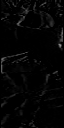

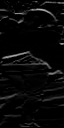

In [7]:
gradx, grady = grads(pedestrian[0])
cv2_imshow(gradx)
cv2_imshow(grady)

In [8]:
def get_dir_vecs(gradx, grady):
  mag = np.sqrt(np.square(gradx) + np.square(grady))
  angle = np.arctan(np.abs(grady)/(gradx+0.000001))
  return mag, np.degrees(angle)

def get_dir_vecs_cv2(gx, gy):
  # devuelve magnitud y angulo de los gradientes. 
  return cv2.cartToPolar(gx, abs(gy), angleInDegrees=True)


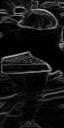

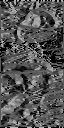

In [9]:
cv2_imshow(get_dir_vecs_cv2(gradx, grady)[0])
cv2_imshow(get_dir_vecs_cv2(gradx, grady)[1])

La implementacion del extractor de caracteristicas HOG se basa en el algoritmo descrito en el siguiente link: [Histogram of Oriented Gradients](https://www.learnopencv.com/histogram-of-oriented-gradients/).


In [10]:
def get_hog(mag, ang):
  '''
  Funcion que genera el histograma dadas la imagen con magnitudes
  y la imagen con las direcciones (o angulos)

  Si la imagen es de tamano 64x128, el histograma de salida es de 8x16
  '''
  # Forma del histograma
  cell_rows = round(mag.shape[0]/8)
  cell_cols = round(mag.shape[1]/8)

  # Inicializamos el histograma con ceros
  hog_hist = np.zeros((cell_rows,cell_cols,9))
  
  # Se recorre el histograma (8x16):
  for r in range (0,cell_rows-1):
    for c in range (0,cell_cols-1):
      # Se va recorriendo la 'imagen' de magnitud y angulo con una ventana de 8x8
      for row in range (r*8,r*8+8):
        for col in range (c*8,c*8+8):
          angle = ang[row][col]
          grad_mag = mag[row][col]

          #caso en que el angulo es multiplo de 20:
          if angle%20 == 0:
            # caso limite
            if angle == 180:
              hog_hist[r][c][0] += grad_mag
              continue
            hog_hist[r][c][int(angle/20)] += grad_mag
            continue
          # En caso que haya que dividir el voto:
          bin_l = int(angle/20)

          if bin_l < 8:
            bin_r = bin_l + 1
            hog_hist[r][c][bin_r] += grad_mag*((angle - (bin_l * 20))/20)
            hog_hist[r][c][bin_l] += grad_mag*(((bin_r * 20) - angle)/20)
          # Caso angulo entre [160,180).
          else:
            bin_r = 0
            hog_hist[r][c][bin_r] += grad_mag*((angle - 160)/20)
            hog_hist[r][c][bin_l] += grad_mag*((180 - angle)/20)
  return hog_hist

Para la normalizacion de los histogramas, nos basamos en la documentacion y codigo fuente de Scikit-image: 
https://github.com/scikit-image/scikit-image/blob/d254263605c6c173c563258d51f44e65782d4365/skimage/feature/_hog.py#L22

La norma utilizada corresponde a la norma L2.


In [11]:
from numpy import ravel

def hog_norm(hog_hist, eps = 1e-5):
  normalized_blocks = np.zeros((hog_hist.shape[0]-1, hog_hist.shape[1]-1,
                                  2, 2, 9))
  for r in range(hog_hist.shape[0]-1):
    for c in range(hog_hist.shape[1]-1):
      block = hog_hist[r:r + 2, c:c + 2, :]
      
      normalized_blocks[r, c, :] = block / np.sqrt(np.sum(block ** 2) + eps ** 2)
  
  normalized_blocks = normalized_blocks.ravel()
  return normalized_blocks

In [12]:
mag, ang = get_dir_vecs_cv2(gradx, grady)

In [13]:
holo = hog_norm(get_hog(mag, ang))
holo.shape

(3780,)

In [14]:
# Separamos en train y test:

from sklearn.model_selection import train_test_split

ped_train, ped_test = train_test_split(pedestrian, test_size=0.3, random_state=42)
chair_train, chair_test = train_test_split(chair, test_size=0.3, random_state=42)
car_side_train, car_side_test = train_test_split(car_side, test_size=0.3, random_state=42)

print(len(ped_train))
print(len(chair_train))
print(len(car_side_train))

129
43
86


Se etiquetaran los datos de la siguiente forma:
```
pedestrian -> 0
chair -> 1
car_side -> 2
```

De esta forma, no hay que hacer transformaciones en las etiquetas debido a que son `str`. 

Se aclara en todo caso que para los entrenamientos de los modelos, se utiliza deteccion binaria: 
```
pedestrian -> 0
no pedestrian -> 1
```

Esto no genera diferencias en el desempeno de los modelos obtenidos. Para el conjunto de test se utilizan las 3 clases. 

In [22]:
# Debemos etiquetar los datos ahora
# Si BINARY_CLF entonces solo habra dos clases: pedestrian y no pedestrian. 
# De otra forma, habra 3: pedestrian, chair, car_side.

BINARY_CLF = False
y_ped = np.zeros(len(ped_train))
if BINARY_CLF:
  y_chair = np.ones(len(chair_train))
  y_car_side = np.ones(len(car_side_train))
else:
  y_chair = np.ones(len(chair_train))
  y_car_side = 2 * np.ones(len(car_side_train))

X = np.asarray(ped_train + chair_train + car_side_train)
y = np.concatenate([y_ped, y_chair, y_car_side])

from sklearn.utils import shuffle
X,  y_train = shuffle(X,  y, random_state=0)

In [23]:
# aplicamos hog a cada X_train:
X_train = []
for x in X:
  gradx, grady = grads(x)
  mag, ang = get_dir_vecs_cv2(gradx, grady)
  temp = hog_norm(get_hog(mag, ang))
  X_train.append(np.float32(temp))

In [17]:
print(len(X_train))
print(len(y_train))


258
258


In [25]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
#evaluation
from sklearn.model_selection import cross_val_score

In [26]:
svm = SVC()
svm.fit(X_train,y_train)
print("accuracy: " + str(np.average(cross_val_score(svm, X_train, y_train, scoring='accuracy'))))


accuracy: 0.9804675716440423


En la siguiente celda, se define una grilla de parametros para realizar la busqueda:

In [42]:
param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': ['auto', 1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]}


clf = GridSearchCV(
    SVC(), param_grid, scoring='accuracy'
)

clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 10, 100, 1000],
                         'gamma': ['auto', 0.001, 0.0001],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [43]:
print("Mejore parametro en el train set: \n")
print(clf.best_params_)
print("\nResultado obtenido con mejores parametros en el train set: {:.2f}".format(max(clf.cv_results_['mean_test_score'])))


print("\n Rendimiento durante la busqueda de hiperparametros en el train set: \n ")
means = clf.cv_results_['mean_test_score']
for mean,  params in zip(means, clf.cv_results_['params']):
    print('Acurracy = {:.2f} para los siguientes parametros: {}\n'.format(mean, params))

Mejores parametros en el train set: 

{'C': 1000, 'gamma': 0.001, 'kernel': 'poly'}

Resultado obtenido con mejores parametros en el train set: 0.98

 Rendimiento durante la busqueda de hiperparametros en el train set: 
 
Acurracy = 0.97 para los siguientes parametros: {'C': 1, 'gamma': 'auto', 'kernel': 'linear'}

Acurracy = 0.50 para los siguientes parametros: {'C': 1, 'gamma': 'auto', 'kernel': 'poly'}

Acurracy = 0.50 para los siguientes parametros: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}

Acurracy = 0.50 para los siguientes parametros: {'C': 1, 'gamma': 'auto', 'kernel': 'sigmoid'}

Acurracy = 0.97 para los siguientes parametros: {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}

Acurracy = 0.50 para los siguientes parametros: {'C': 1, 'gamma': 0.001, 'kernel': 'poly'}

Acurracy = 0.82 para los siguientes parametros: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}

Acurracy = 0.56 para los siguientes parametros: {'C': 1, 'gamma': 0.001, 'kernel': 'sigmoid'}

Acurracy = 0.97 para los sigui

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier(random_state = 42)

param_grid_rf = {
    'bootstrap': [True, False],
    'max_depth': [10,  25,  50, 75, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 500, 1000, 1250, 1500]
}

rf_clf = RandomizedSearchCV(rf, param_grid_rf, scoring='accuracy', n_jobs = -1, verbose=3, n_iter=30, cv=3)
rf_clf.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  5.1min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [60]:
print("Mejore parametro en el train set: \n")
print(rf_clf.best_params_)
print("\nResultado obtenido con mejores parametros en el train set: {:.2f}".format(max(rf_clf.cv_results_['mean_test_score'])))

Mejore parametro en el train set: 

{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 75, 'bootstrap': False}

Resultado obtenido con mejores parametros en el train set: 0.90


In [62]:
# Probemos ahora en el conjunto de test:
# Si BINARY_CLF entonces solo habra dos clases: pedestrian y no pedestrian. 
# De otra forma, habra 3: pedestrian, chair, car_side.

y_ped_test = np.zeros(len(ped_test))
# Para el conjunto de test se usaran los dos mejores modelos y se hara clasificacion 
# multiclase para observar la matriz de confusion:
y_chair_test = np.ones(len(chair_test))
y_car_side_test = 2 * np.ones(len(car_side_test))

X_test_temp = np.asarray(ped_test + chair_test + car_side_test)
y_test = np.concatenate([y_ped_test, y_chair_test, y_car_side_test])

from sklearn.utils import shuffle
X_test_temp,  y_test = shuffle(X_test_temp,  y_test, random_state=0)

In [63]:
# aplicamos hog a cada X_train:
X_test = []
for x in X_test_temp:
  gradx, grady = grads(x)
  mag, ang = get_dir_vecs_cv2(gradx, grady)
  temp = hog_norm(get_hog(mag, ang))
  X_test.append(np.float32(temp))

Confusion matrix, SVC
[[56  0  0]
 [ 3 16  0]
 [ 1  0 36]]
Confusion matrix, RF
[[56  0  0]
 [ 2 13  4]
 [ 6  1 30]]


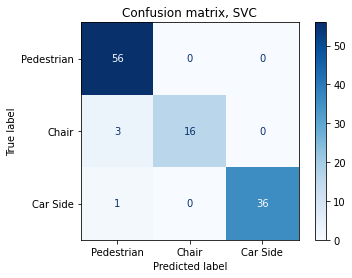

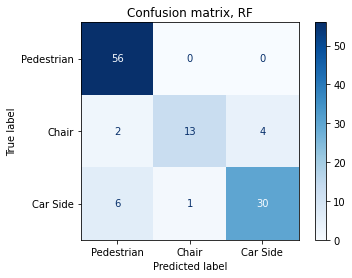

In [67]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

options = [("Confusion matrix, SVC", clf),
                  ("Confusion matrix, RF", rf_clf)]
for title, clf in options:
    disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=['Pedestrian', 'Chair', 'Car Side'],
                                 cmap=plt.cm.Blues,
                                 normalize=None)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

- Se destaca en primer lugar que el modelo SVC obtiene resultados considerablemente mejores tanto en `accuracy` como al observar la matriz de confusion. 

- Una opcion a considerar para mejorar los resultados corresponde a incluir mas parametros en la busqueda de grilla.

- Por otro lado, se podria considerar cambiar la configuracion en la cual se calculan las caracteristicas HOG: aumentar el tamano de la celda (en lugar de 8x8, aumentarlo a 10x10 por ejemplo) y hacer que se traslapen al extraer informacion. De esta forma el vector final tendria mas componentes. 

- Existe otra opcion que es generando 'data augmentation', esto es, rotar aleatoriamente la imagen, hacer recortes aleatorios y otros para que el modelo generalice mejor y sea menos variante ante cambios pequenos en las imagenes. 



# Conclusion.
- En la tarea se comprendio la utilidad de elemntos implementados antes como los gradientes en `x` e `y`. 

- Se comprendio sobre como implementar el extractor de caracteristicas sobel y sobre la complegidad que este tiene (en adelante, se usara la funcion de `cv2`). 

- Se aprendio que hacer una buena extraccion de caracteristicas puede ser tanto o mas importante que el modelo en si mismo: con un modelo simple y pocas imagenes de entrenamiento se pudo obtener un $98\%$ de _accuracy_ en clasificacion multiclase. 